In [ ]:
import scipy

from tensorflow.python.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, LeakyReLU
from tensorflow.python.keras.layers import BatchNormalization, Add, add
from tensorflow.python.keras.layers import UpSampling2D, Conv2D
from tensorflow.python.keras.applications import vgg19
#from tensorflow.python.keras.utils import plot_model
from keras.utils import plot_model
#from tensorflow.python.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import img_to_array, load_img
#from tensorflow.python.keras.models import Sequential, Model
from keras.models import Sequential, Model
#from tensorflow.python.keras.optimizers import Adam
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.python.keras.backend as K
from tqdm import tqdm

from tensorflow.python.platform.tf_logging import set_verbosity, FATAL
#отключаем отображение некритических предупреждений
set_verbosity(FATAL)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '0'

In [ ]:
#подключаем google drive, чтобы достать из него необходимый dataset
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_shape = (256, 384, 3) #размер изображения
height = img_shape[0]
width = img_shape[1]

In [ ]:
!unzip -q '/content/drive/My Drive/datasets/images/Самолеты.zip'


In [ ]:
!ls '/content/База/Airplane/'

airplane_1000.jpg  airplane_325.jpg  airplane_550.jpg  airplane_776.jpg
airplane_100.jpg   airplane_326.jpg  airplane_551.jpg  airplane_777.jpg
airplane_101.jpg   airplane_327.jpg  airplane_552.jpg  airplane_778.jpg
airplane_102.jpg   airplane_328.jpg  airplane_553.jpg  airplane_779.jpg
airplane_103.jpg   airplane_329.jpg  airplane_554.jpg  airplane_77.jpg
airplane_104.jpg   airplane_32.jpg   airplane_555.jpg  airplane_780.jpg
airplane_105.jpg   airplane_330.jpg  airplane_556.jpg  airplane_781.jpg
airplane_106.jpg   airplane_331.jpg  airplane_557.jpg  airplane_782.jpg
airplane_107.jpg   airplane_332.jpg  airplane_558.jpg  airplane_783.jpg
airplane_108.jpg   airplane_333.jpg  airplane_559.jpg  airplane_784.jpg
airplane_109.jpg   airplane_334.jpg  airplane_55.jpg   airplane_785.jpg
airplane_10.jpg    airplane_335.jpg  airplane_560.jpg  airplane_786.jpg
airplane_110.jpg   airplane_336.jpg  airplane_561.jpg  airplane_787.jpg
airplane_111.jpg   airplane_337.jpg  airplane_562.jpg  airplane_7

In [ ]:
PATH = '/content/База/Airplane/'
mask = '/content/База/Segment/'
imgs = [] 
for image in sorted(os.listdir(PATH)): #проходим по каждому файлу, получив список файлов в папке 
  print(image)
  imgs.append(img_to_array(load_img(PATH + image, target_size=(height, width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
imgs = np.stack(imgs).astype('uint8') #сохраняем итоговый массив изображений

masks = []
for image in sorted(os.listdir(mask)): #проходим по каждому файлу, получив список файлов в папке 
  masks.append(img_to_array(load_img(mask + image, target_size=(height, width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
masks = np.stack(masks).astype('uint8') #сохраняем итоговый массив масок

airplane_1.jpg
airplane_10.jpg
airplane_100.jpg
airplane_1000.jpg
airplane_101.jpg
airplane_102.jpg
airplane_103.jpg
airplane_104.jpg
airplane_105.jpg
airplane_106.jpg
airplane_107.jpg
airplane_108.jpg
airplane_109.jpg
airplane_11.jpg
airplane_110.jpg
airplane_111.jpg
airplane_112.jpg
airplane_113.jpg
airplane_114.jpg
airplane_115.jpg
airplane_116.jpg
airplane_117.jpg
airplane_118.jpg
airplane_119.jpg
airplane_12.jpg
airplane_120.jpg
airplane_121.jpg
airplane_122.jpg
airplane_123.jpg
airplane_124.jpg
airplane_125.jpg
airplane_126.jpg
airplane_127.jpg
airplane_128.jpg
airplane_129.jpg
airplane_13.jpg
airplane_130.jpg
airplane_131.jpg
airplane_132.jpg
airplane_133.jpg
airplane_134.jpg
airplane_135.jpg
airplane_136.jpg
airplane_137.jpg
airplane_138.jpg
airplane_139.jpg
airplane_14.jpg
airplane_140.jpg
airplane_141.jpg
airplane_142.jpg
airplane_143.jpg
airplane_144.jpg
airplane_145.jpg
airplane_146.jpg
airplane_147.jpg
airplane_148.jpg
airplane_149.jpg
airplane_15.jpg
airplane_150.jpg
airp

In [ ]:
def build_generator():
    gf = 64
    def conv2d(layer_input, filters, f_size=4, bn=True): 
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0): 
        u = UpSampling2D(size=2)(layer_input) 
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u
    
    d0 = Input(shape=img_shape, name="condition")
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4) 
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8) 
    u3 = deconv2d(u2, d4, gf*8) 
    u4 = deconv2d(u3, d3, gf*4) 
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh', name='G_output')(u7)
    return Model(d0, output_img, name="G")

def build_discriminator():
  df = 64
  def d_layer(layer_input, filters, f_size=4, bn=True):
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
      if bn:
          d = BatchNormalization(momentum=0.8)(d)
      return d

  image = Input(shape=img_shape, name="real_or_fake_A")
  condition = Input(shape=img_shape, name="condition")
  combined_imgs = Concatenate(axis=-1)([image, condition])
  d1 = d_layer(combined_imgs, df, bn=False)
  d2 = d_layer(d1, df*2)
  d3 = d_layer(d2, df*4) 
  d4 = d_layer(d3, df*8)
  validity = Conv2D(1, kernel_size=4, strides=1, padding='same', name='D_output', activation='sigmoid')(d4)
  return Model([image, condition], validity, name='D')

In [ ]:
#создаем генератор
gen = build_generator() 
gen.summary()

Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 192, 64) 3136        condition[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 192, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 96, 128)  131200      leaky_re_lu[0][0]                
__________________________________________________________________________________________________

In [ ]:
dis = build_discriminator()
dis.summary()

Model: "D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
real_or_fake_A (InputLayer)     [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 256, 384, 6)  0           real_or_fake_A[0][0]             
                                                                 condition[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 192, 64) 6208        concatenate_6[0][0]              

In [ ]:
def build_vgg():
  #для feature loss создаем vgg модель
  vgg_in = Input(img_shape)
  vgg = vgg19.VGG19(include_top=False, input_shape=img_shape, input_tensor=vgg_in)
  vgg_out = vgg.get_layer('block5_conv4').output
  vgg = Model(vgg_in, vgg_out, name='vgg')
  vgg.trainable = False 
  return vgg

In [ ]:
vgg = build_vgg()
vgg.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 192, 128)     147584    
________________________________________________________________

In [ ]:
def build_gan(generator, discriminator, vgg):
  discriminator.trainable = False
  condition = Input(img_shape, name='Condition')
  fake_img = generator(condition)
  fake_features = vgg(fake_img)
  fake_validity = discriminator([fake_img, condition])
  gan = Model(condition, [fake_validity, fake_img, fake_features])
  return gan

def train(generator, discriminator, gan, vgg, imgs, masks, epochs, batch_size):
  for epoch in range(epochs): 
    idx = np.random.choice(imgs.shape[0], imgs.shape[0], replace=False) 
    with tqdm(total=imgs.shape[0]) as pbar:
      for batch in range(imgs.shape[0]//batch_size):
        y_real = np.ones((batch_size, *discriminator.output_shape[1:])) - np.random.random_sample((batch_size, *discriminator.output_shape[1:])) * 0.2
        y_fake = np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2
        idx_batch = idx[batch*batch_size:(batch+1)*batch_size] 
        real_imgs = (imgs[idx_batch]/127.5) - 1 
        condition = (masks[idx_batch]/127.5) - 1
        fake_imgs = generator.predict(condition)
        d_loss_real = discriminator.train_on_batch([real_imgs, condition], y_real)
        d_loss_fake = discriminator.train_on_batch([fake_imgs, condition], y_fake)
        d_loss_total = 0.5 * np.add(d_loss_real, d_loss_fake)
        real_features = vgg.predict(real_imgs)
        y_real = np.ones((batch_size, *discriminator.output_shape[1:]))
        g_loss = gan.train_on_batch(condition, [y_real, real_imgs, real_features])
        pbar.update(batch_size)
        pbar.set_description("Epoch: {}/{}, Discriminator loss: {}, Generator loss:{}".format(epoch+1, epochs, d_loss_total[0], g_loss))

In [ ]:
gen = build_generator() 
dis = build_discriminator()
dis.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, beta_1=0.5), metrics=['accuracy'])

vgg = build_vgg()
gan = build_gan(gen, dis, vgg)
gan.compile(loss=['binary_crossentropy', 'mse', 'mse'], loss_weights=[1,100,10], optimizer=Adam(lr=1e-4, beta_1=0.5))

In [ ]:
# тренируем модель
train(gen, dis, gan, vgg, imgs, masks, 15, 16)

Epoch: 1/15, Discriminator loss: 0.6696618497371674, Generator loss:[21.706151962280273, 1.0381178855895996, 0.20177428424358368, 0.0490603893995285]:  99%|█████████▉| 992/1000 [01:12<00:00, 13.74it/s]
Epoch: 2/15, Discriminator loss: 0.5841333866119385, Generator loss:[20.518230438232422, 1.2863636016845703, 0.18756313621997833, 0.04755541309714317]:  99%|█████████▉| 992/1000 [00:47<00:00, 20.74it/s]
Epoch: 3/15, Discriminator loss: 0.5823038518428802, Generator loss:[25.225915908813477, 1.5810636281967163, 0.2318163365125656, 0.04632185772061348]:  99%|█████████▉| 992/1000 [00:48<00:00, 20.61it/s]
Epoch: 4/15, Discriminator loss: 0.568371057510376, Generator loss:[20.746013641357422, 1.5561634302139282, 0.18689455091953278, 0.0500393845140934]:  99%|█████████▉| 992/1000 [00:48<00:00, 20.52it/s]
Epoch: 5/15, Discriminator loss: 0.7229691445827484, Generator loss:[14.76673698425293, 1.8391205072402954, 0.1250431388616562, 0.04233025014400482]:  99%|█████████▉| 992/1000 [00:48<00:00, 20

In [ ]:
def sample_image(generator, imgs, masks, idx):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(masks[idx])
    ax[0].set_title('маска')
    condition = masks[idx] / 127.5 - 1
    generated = (generator.predict(condition[None]) + 1) * 127.5
    ax[1].imshow(generated[0].astype('uint8'))
    ax[1].set_title('сгенерированное изображение')
    ax[2].imshow(imgs[idx]) 
    ax[2].set_title('реальное изображение')



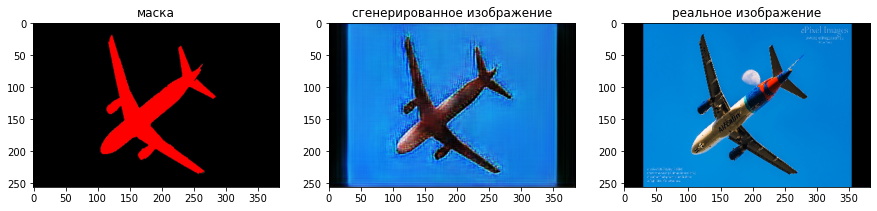

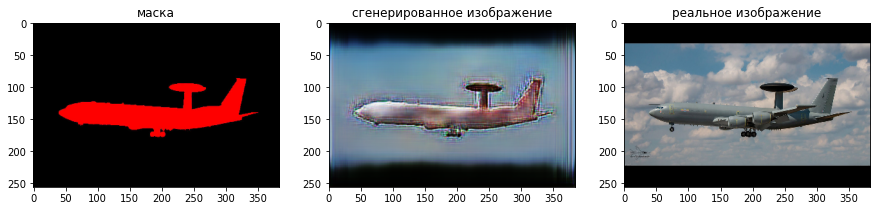

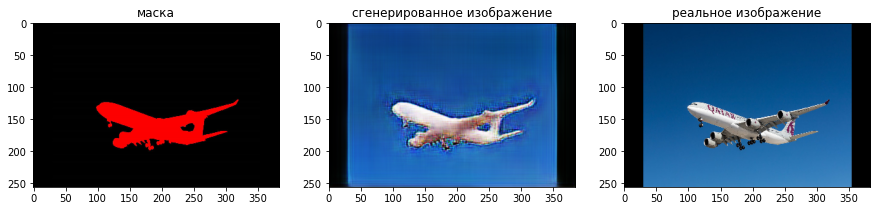

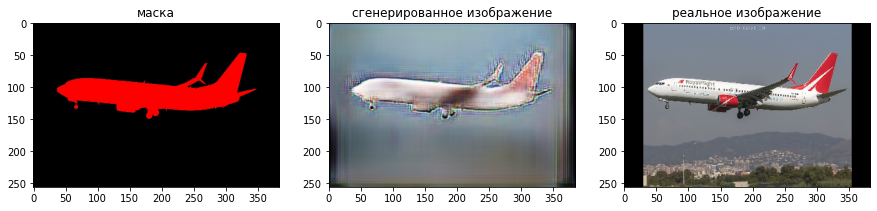

In [ ]:
for i in [20,100,300,500]:
   sample_image(gen, imgs, masks, i)